1. First, we import all the necessary packages

In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()


2025-11-01 21:23:20.455659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-01 21:23:24.186790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-01 21:23:38.348018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


0it [00:00, ?it/s]

In [3]:
# ...existing code...
import os
import tensorflow as tf

print("tf", tf.__version__)
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())

# Enable memory growth (do this before any GPU allocation)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except RuntimeError as e:
        print("Memory growth config failed:", e)

# Optional: enable mixed precision for speed on supported GPUs
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # comment out if you get numeric issues

# Optional: limit visible GPUs
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# (Remove or comment out device placement logging after verification)
# tf.debugging.set_log_device_placement(True)

# quick test (will show device in output)
a = tf.constant([1.0])
with tf.device('/GPU:0'):
    b = a * 2.0
print("test op device:", b.device)
# ...existing code...

tf 2.20.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
test op device: /job:localhost/replica:0/task:0/device:GPU:0


I0000 00:00:1762010624.515495   22121 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [47]:
# ...existing code...
import os, sys, ctypes, ctypes.util
import tensorflow as tf

print("Python executable:", sys.executable)
print("TF version:", tf.__version__)
print("CUDA visible env:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("physical GPUs:", tf.config.list_physical_devices('GPU'))
print("logical GPUs:", tf.config.list_logical_devices('GPU'))
print("GPU device name (test):", tf.test.gpu_device_name())
print("TF lib path:", tf.sysconfig.get_build_info().get("cuda_version", "no-cuda-version-info"))
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))

# check cudart library resolution
lib = ctypes.util.find_library('cudart')
print("cudart lib found by ctypes:", lib)
try:
    if lib: ctypes.CDLL(lib)
    print("cudart loads OK")
except Exception as e:
    print("cudart load error:", e)
# ...existing code...

Python executable: /home/sifat/Data/Img_cap_gen/.venv/bin/python
TF version: 2.20.0
CUDA visible env: None
TF built with CUDA: True
physical GPUs: []
logical GPUs: []
GPU device name (test): 
TF lib path: 12.5.1
LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
cudart lib found by ctypes: libcudart.so.12
cudart loads OK


W0000 00:00:1761758002.135128  864962 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
import tensorflow as tf
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("cuDNN enabled:", tf.test.is_built_with_cuda())

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
cuDNN enabled: True


2. Getting and performing data cleaning

In [4]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
dataset_text = "/home/sifat/Data/Img_cap_gen/Flickr8k_text"
dataset_images = "/home/sifat/Data/Img_cap_gen/Flicker8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


3. Extracting the feature vector from all images 

In [5]:
# ...existing code...
def extract_features(directory):
    # create Xception model once per call (loads pretrained weights)
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        filename = os.path.join(directory, img_name)
        try:
            # load as PIL -> numpy with target size
            image = load_img(filename, target_size=(299, 299))
            image = img_to_array(image)
        except Exception:
            # skip files that cannot be opened as images
            continue
        # if image has alpha channel, drop it
        if image.shape[-1] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        # use Xception preprocessing (scales to [-1, 1])
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        features[img_name] = feature
    return features

# ...existing code...
# 2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

2025-11-01 21:23:58.675849: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-11-01 21:23:58.696783: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e7cd4004760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-01 21:23:58.696797: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-11-01 21:23:58.751892: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-01 21:23:59.363287: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
I0000 00:00:1762010646.169890   22382 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

4. Loading dataset for Training the model

In [6]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

5. Tokenizing the vocabulary 

In [7]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [8]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

6. Create Data generator

In [9]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ((input_image, input_sequence), output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

7. Defining the CNN-RNN model

In [10]:
from keras.utils import plot_model

# define the captioning model
# ...existing code...
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model
# ...existing code...

8. Training the model

In [11]:
# ...existing code...
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# make sure models directory exists
os.makedirs("models", exist_ok=True)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    # use model.fit with a generator (fit_generator removed)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(os.path.join("models", f"model_{i}.h5"))
# ...existing code...

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │  1,939,712 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 107s 17ms/step - accuracy: 0.2341 - loss: 4.5095


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.2923 - loss: 3.6659


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 99s 17ms/step - accuracy: 0.3107 - loss: 3.3896


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 102s 17ms/step - accuracy: 0.3235 - loss: 3.2245


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 103s 17ms/step - accuracy: 0.3302 - loss: 3.1087


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 103s 17ms/step - accuracy: 0.3374 - loss: 3.0281


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.3416 - loss: 2.9594


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.3466 - loss: 2.9098


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.3505 - loss: 2.8730


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 96s 16ms/step - accuracy: 0.3536 - loss: 2.8331


9. Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step



start dog is running through the water end


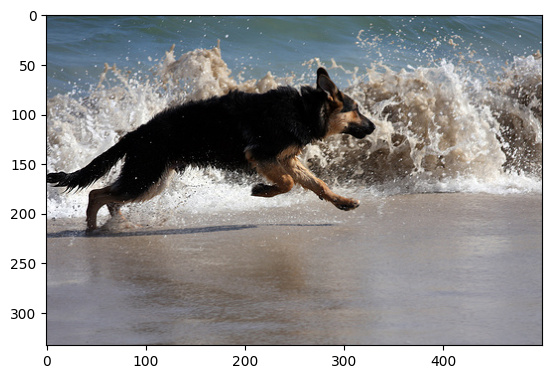

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# import argparse


# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

img_path = "/home/sifat/Data/Img_cap_gen/Flicker8k_Dataset/3704431444_f337ec2b90.jpg"  # <-- change to your desired image

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)